In [78]:
import os
import scipy
from skimage.transform import resize
import numpy as np
import tqdm
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import backend as K
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Softmax,Input,Flatten
from keras.optimizers import Adam,RMSprop,SGD
from keras.layers.merge import add
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import BatchNormalization

K.set_image_data_format('channels_last')

%matplotlib inline

Training Set

In [79]:
train0_namelist = os.listdir('chest_xray/train/NORMAL')
train0_namelist = train0_namelist[1:]
train1_namelist = os.listdir('chest_xray/train/PNEUMONIA')
train1_namelist = train1_namelist[1:]
num_train0 = len(train0_namelist)
print ('Num of Normal in Train = ', num_train0)
num_train1 = len(train1_namelist)
print ('Num of Pneumonia in Train = ', num_train1)
print ('Training Data Size = ' , num_train0 + num_train1)

Num of Normal in Train =  1341
Num of Pneumonia in Train =  3875
Training Data Size =  5216


In [80]:
Train_x = []
Train_y = []
for image_name in tqdm(train0_namelist):
    im = cv2.imread('chest_xray/train/NORMAL/' + image_name)
    im = resize(im/255.,(64,64,3))
    #im = scipy.misc.imresize(im,(128,128,3))
    Train_x.append(im)
    Train_y.append(0)
    
for image_name in tqdm(train1_namelist):
    im = cv2.imread('chest_xray/train/PNEUMONIA/' + image_name)
    im = resize(im/255.,(64,64,3))
    #im = scipy.misc.imresize(im,(128,128,3))
    Train_x.append(im)
    Train_y.append(1)  
    
      

  0%|          | 0/1341 [00:00<?, ?it/s]/Users/allen/env/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/allen/env/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 3875/3875 [02:35<00:00, 24.95it/s]


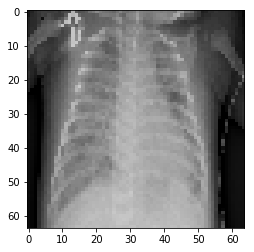

In [81]:
Train_x = np.array(Train_x)
Train_y = np.array(Train_y)
plt.imshow(Train_x[1341,:,:,:]) 

Test Set

In [82]:
test0_namelist = os.listdir('chest_xray/test/NORMAL')
test0_namelist = test0_namelist[1:]
test1_namelist = os.listdir('chest_xray/test/PNEUMONIA')
test1_namelist = test1_namelist[1:]
num_test0 = len(test0_namelist)
print ('Num of Normal in Test = ', num_test0)
num_test1 = len(test1_namelist)
print ('Num of Pneumonia in Test = ', num_test1)
print ('Training Data Size = ' , num_test0 + num_test1)

Num of Normal in Test =  233
Num of Pneumonia in Test =  389
Training Data Size =  622


In [83]:
Test_x = []
Test_y = []
for image_name in tqdm(test0_namelist):
    im = cv2.imread('chest_xray/test/NORMAL/' + image_name)
    im = resize(im,(64,64,3))
    #im = scipy.misc.imresize(im,(128,128,3))
    Test_x.append(im)
    Test_y.append(0)
    
for image_name in tqdm(test1_namelist):
    im = cv2.imread('chest_xray/test/PNEUMONIA/' + image_name)
    im = resize(im,(64,64,3))
    #im = scipy.misc.imresize(im,(128,128,3))
    Test_x.append(im)
    Test_y.append(1)  
    
Test_x = np.asarray(Test_x)
Test_y = np.asarray(Test_y)

Train_y = to_categorical(Train_y)
Test_y = to_categorical(Test_y)

print('Train_x.shape:',Train_x.shape)
print('Test_x.shape:',Test_x.shape)
print('Train_y.shape:',Train_y.shape)
print('Test_y.shape:',Test_y.shape)

  0%|          | 0/233 [00:00<?, ?it/s]/Users/allen/env/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/allen/env/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 389/389 [00:11<00:00, 35.13it/s]

Train_x.shape: (5216, 64, 64, 3)
Test_x.shape: (622, 64, 64, 3)
Train_y.shape: (5216, 2)
Test_y.shape: (622, 2)


In [84]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same",
                 input_shape=(64,64,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
model.add(Dense(2, activation="softmax"))

In [85]:
model.compile(Adam(lr=0.01),loss="categorical_crossentropy", metrics=["accuracy"])

In [86]:
model.fit(Train_x,Train_y,epochs=2,batch_size=64)

Epoch 1/2
5216/5216 [==============================] - 99s 19ms/step - loss: 0.4421 - acc: 0.9022
Epoch 2/2
5216/5216 [==============================] - 97s 19ms/step - loss: 0.2537 - acc: 0.9268


In [87]:
temp  = model.evaluate(Test_x,Test_y)
print ('Loss of test set = ', temp[0])
print ('Accuracy = ', temp[1])

622/622 [==============================] - 4s 6ms/step
Loss of test set =  1.0478083171082175
Accuracy =  0.8360128617363344


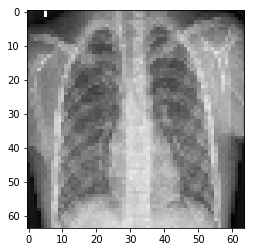

In [105]:
plt.imshow(Test_x[10,:,:,:])

In [106]:
prob = model.predict(np.expand_dims(Test_x[70,:,:,:], axis=0))
print ('P(Normal) = ', prob[0][0])
print ('P(Pneumonia) = ', prob[0][1])

if prob[0][0] > prob[0][1]:
    print ('Normal')
elif prob[0][0] < prob[0][1]:
    print ('Pneumonia')
else:
    print ('Equal probability')

P(Normal) =  0.98831314
P(Pneumonia) =  0.011686856
Normal
